<a href="https://colab.research.google.com/github/hshu1000/Predicting-Heat-Stroke-Prone-Areas-in-the-Greater-Los-Angeles/blob/main/Hannah_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import plotly as py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import griddata
from scipy.interpolate import griddata
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('3626689.csv')

df_cleaned = df.drop('TMAX_ATTRIBUTES', axis = 1).drop('TMIN_ATTRIBUTES', axis = 1).drop('TAVG', axis = 1).drop('TAVG_ATTRIBUTES', axis = 1).drop("TMIN", axis = 1)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TMAX
0,USR0000CCP9,"CAMP 9 CALIFORNIA, CA US",34.36170,-118.421700,1219.2,2004-01-01,48.0
1,USR0000CCP9,"CAMP 9 CALIFORNIA, CA US",34.36170,-118.421700,1219.2,2004-01-02,42.0
2,USR0000CCP9,"CAMP 9 CALIFORNIA, CA US",34.36170,-118.421700,1219.2,2004-01-03,34.0
3,USR0000CCP9,"CAMP 9 CALIFORNIA, CA US",34.36170,-118.421700,1219.2,2004-01-04,45.0
4,USR0000CCP9,"CAMP 9 CALIFORNIA, CA US",34.36170,-118.421700,1219.2,2004-01-05,42.0
...,...,...,...,...,...,...,...
903280,US1CALA0029,"CARSON 0.7 NW, CA US",33.84374,-118.264861,4.6,2012-01-23,NaN
903281,US1CALA0029,"CARSON 0.7 NW, CA US",33.84374,-118.264861,4.6,2012-01-24,NaN
903282,US1CALA0029,"CARSON 0.7 NW, CA US",33.84374,-118.264861,4.6,2012-02-13,NaN
903283,US1CALA0029,"CARSON 0.7 NW, CA US",33.84374,-118.264861,4.6,2012-02-16,NaN


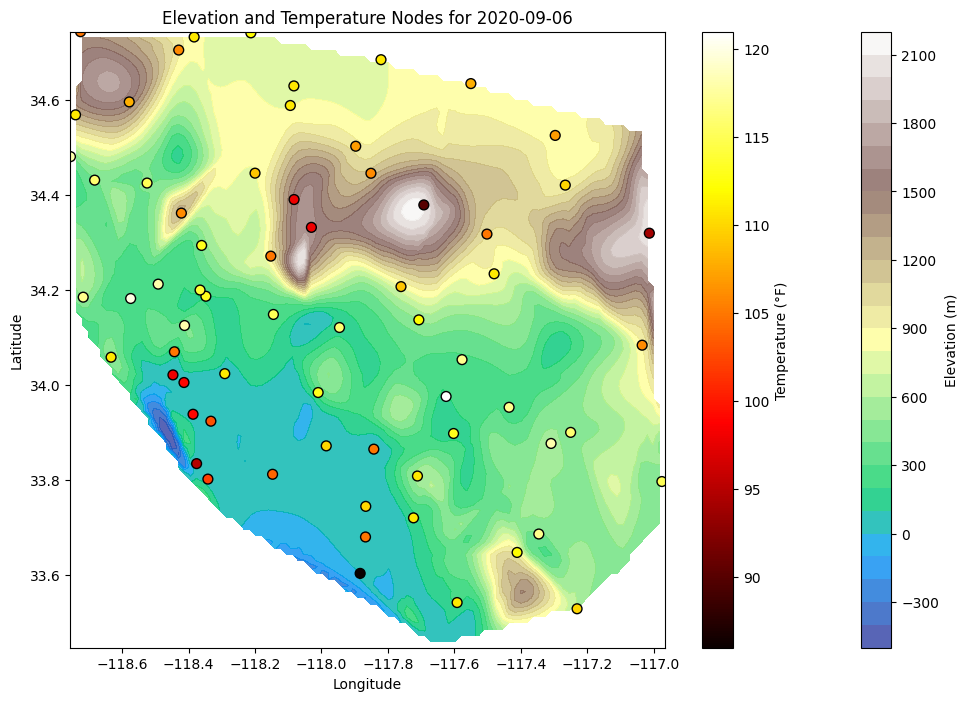

In [ ]:
#HEAT and ELEVATION

# Prepare the grid for elevation data
grid_x, grid_y = np.meshgrid(
    np.linspace(df_cleaned['LONGITUDE'].min(), df_cleaned['LONGITUDE'].max(), 100),
    np.linspace(df_cleaned['LATITUDE'].min(), df_cleaned['LATITUDE'].max(), 100)
)

# Interpolate elevation data onto the grid
grid_z_elevation = griddata(
    (df_cleaned['LONGITUDE'], df_cleaned['LATITUDE']),
    df_cleaned['ELEVATION'],
    (grid_x, grid_y),
    method='cubic'
)

# Filter the temperature data for a specific date
specific_date = '2020-09-06'
df_specific_day = df_cleaned[df_cleaned['DATE'] == specific_date]

# Plotting
plt.figure(figsize=(12, 8))

# Elevation contour map
plt.contourf(grid_x, grid_y, grid_z_elevation, levels=30, cmap='terrain', alpha=0.8)
plt.colorbar(label='Elevation (m)')

# Overlaying temperature data as colored nodes
# The color of each node is determined by its 'TMAX' value
scatter = plt.scatter(df_specific_day['LONGITUDE'], df_specific_day['LATITUDE'], c=df_specific_day['TMAX'], cmap='hot', edgecolor='k', s=50)
plt.colorbar(scatter, label='Temperature (°F)')

plt.title(f'Elevation and Temperature Nodes for {specific_date}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
#INTERPOLATE DATA
df_cleaned['DATE'] = pd.to_datetime(df_cleaned['DATE'])

df_summer = df_cleaned[df_cleaned['DATE'].dt.month.isin([6, 7, 8])]

df_summer = df_summer[df_summer['DATE'].dt.year != 2023]

df_summer['temp'] = df_summer.groupby('NAME')['TMAX'].transform(lambda group: group.interpolate(method='linear'))

overall_mean_tmax = df_summer['temp'].mean()

df_summer['temp'] = df_summer['temp'].fillna(overall_mean_tmax)

df_summer['temp'] = df_summer['temp'].ffill().bfill()


df_summer1 = df_summer.sort_values(by=['DATE', 'NAME'], ascending=True)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TMAX,temp
670293,USR0000CACT,"ACTON CALIFORNIA, CA US",34.445800,-118.200000,792.5,2004-06-01,95.0,95.000000
630682,USC00040014,"ACTON ESCONDIDO CANYON, CA US",34.493800,-118.271300,863.5,2004-06-01,NaN,87.988887
587814,USC00040144,"ALTADENA, CA US",34.182110,-118.138270,343.5,2004-06-01,NaN,87.988887
273217,USC00040192,"ANAHEIM, CA US",33.864700,-117.842500,70.7,2004-06-01,89.0,89.000000
817732,USR0000CBCN,"BELL CANYON CALIFORNIA, CA US",33.541700,-117.591700,213.4,2004-06-01,82.0,82.000000
...,...,...,...,...,...,...,...,...
394183,US1CARV0050,"WINCHESTER 6.5 S, CA US",33.615278,-117.091111,433.4,2022-08-31,NaN,87.988887
402536,USC00049785,"WOODLAND HILLS PIERCE COLLEGE, CA US",34.181900,-118.574400,240.8,2022-08-31,111.0,111.000000
296607,US1CASR0069,"WRIGHTWOOD 4.8 NE, CA US",34.416703,-117.581900,1297.2,2022-08-31,NaN,87.988887
827613,US1CAOR0072,"YORBA LINDA 2.2 WSW, CA US",33.873000,-117.799500,96.3,2022-08-31,NaN,87.988887


In [ ]:
#creating the test dataframe
import pandas as pd

future_years = [2025, 2030, 2035, 2040]

locations = df['NAME'].dropna().astype(str).unique()

future_data = pd.DataFrame()

for year in future_years:
    for month in [6, 7, 8]:  # June, July, August
        start_date = f'{year}-{month:02d}-01'
        end_date = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(1)
        month_dates = pd.date_range(start=start_date, end=end_date)
        temp_df = pd.DataFrame({'DATE': month_dates})
        temp_df['YEAR'] = year
        temp_df['MONTH'] = month
        future_data = pd.concat([future_data, temp_df], ignore_index=True)

locations_df = pd.DataFrame({'NAME': locations})

future_data['key'] = 1
locations_df['key'] = 1
future_data = future_data.merge(locations_df, on='key').drop('key', axis=1)

future_data = future_data.drop('YEAR', axis = 1).drop('MONTH', axis = 1)

future_data['TMAX'] = np.nan

future_data1 = future_data.sort_values(by=['DATE', 'NAME'], ascending=True)

future_data1

,DATE,NAME,TMAX
224,2025-06-01,"ACTON CALIFORNIA, CA US",NaN
208,2025-06-01,"ACTON ESCONDIDO CANYON, CA US",NaN
51,2025-06-01,"ADELANTO 3.1 S, CA US",NaN
60,2025-06-01,"AGOURA HILLS 1.3 NNE, CA US",NaN
159,2025-06-01,"ALISO VIEJO 0.7 SSE, CA US",NaN
...,...,...,...
109639,2040-08-31,"YORBA LINDA 2.2 WSW, CA US",NaN
109608,2040-08-31,"YORBA LINDA, CA US",NaN
109494,2040-08-31,"YUCAIPA 1.5 NNE, CA US",NaN
109583,2040-08-31,"YUCAIPA 2.7 NNE, CA US",NaN


In [ ]:
#defining train and test data
df_train = df_summer1[['NAME', 'temp', 'DATE']]

df_test = future_data1


df_train['YEAR'] = df_train['DATE'].dt.year
df_train['MONTH'] = df_train['DATE'].dt.month
df_train['DAY'] = df_train['DATE'].dt.day

df_test['YEAR'] = df_test['DATE'].dt.year
df_test['MONTH'] = df_test['DATE'].dt.month
df_test['DAY'] = df_test['DATE'].dt.day

<ipython-input-7-883fe57ebd55>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['YEAR'] = df_train['DATE'].dt.year
<ipython-input-7-883fe57ebd55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['MONTH'] = df_train['DATE'].dt.month
<ipython-input-7-883fe57ebd55>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [ ]:
#Predict Temperature of Summer 2024


X_train = df_train[['YEAR', 'MONTH', 'DAY', 'NAME']]
y_train = df_train['temp']
X_test = df_test[['YEAR', 'MONTH', 'DAY', 'NAME']]

#define column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['NAME']),
    ],
    remainder='passthrough'
)

#define pipeline
pipeline = make_pipeline(
    column_transformer,
    RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
)

#fit
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

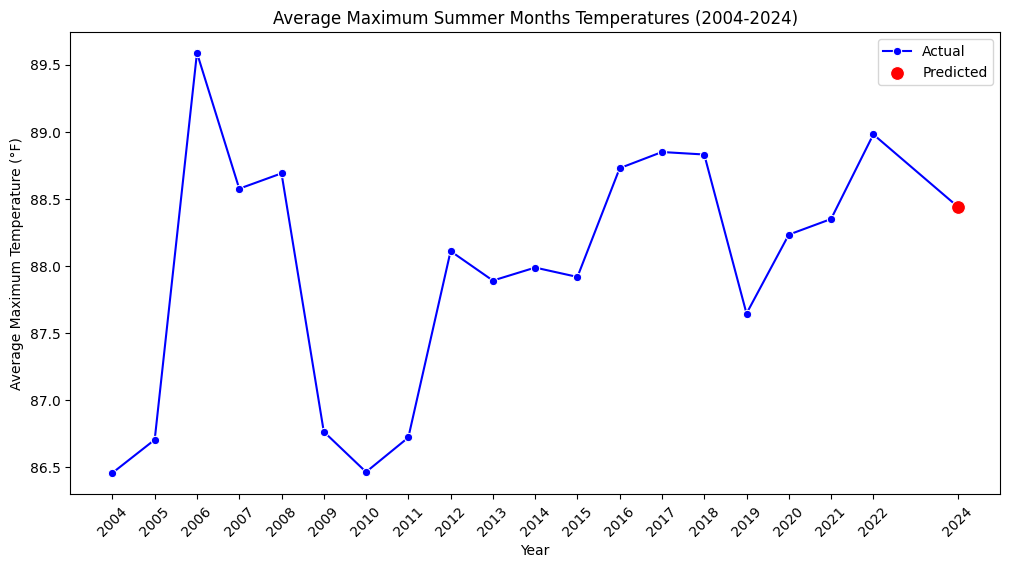

In [ ]:
#calculate average temps by year of training data
average_temps_train = df_train.groupby('YEAR')['temp'].mean().reset_index()

#calculate avg temp of 2024
average_temps_df1 = df1.groupby('YEAR')['max'].mean().reset_index()

average_temps_train.rename(columns={'temp': 'AvgTemp'}, inplace=True)
average_temps_df1.rename(columns={'max': 'AvgTemp'}, inplace=True)

#merge data frames
combined_averages = pd.concat([average_temps_train, average_temps_df1], ignore_index=True)

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='YEAR', y='AvgTemp', data=combined_averages, marker='o', color='b', label='Actual')
sns.scatterplot(x='YEAR', y='AvgTemp', data=combined_averages[combined_averages['YEAR'] == 2024], color='r', s=100, label='Predicted', zorder=5)

plt.title('Average Maximum Summer Months Temperatures (2004-2024)')
plt.xlabel('Year')
plt.ylabel('Average Maximum Temperature (°F)')
plt.xticks(combined_averages['YEAR'], rotation=45)  # Ensure all years are shown and readable

plt.legend()
plt.show()


In [ ]:
#adding location into
station_info = df_summer1[['NAME', 'LATITUDE', 'LONGITUDE']].drop_duplicates()

# Then, merge this station information with df1
df1_with_location = pd.merge(df1, station_info, on='NAME', how='left')

station_info = df_summer1[['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].drop_duplicates()

# Then, merge this station information with df1
df1_with_location = pd.merge(df1, station_info, on='NAME', how='left')


df1_with_location

,DATE,NAME,TMAX,YEAR,MONTH,DAY,max,LATITUDE,LONGITUDE,ELEVATION
0,2025-06-01,"ACTON CALIFORNIA, CA US",NaN,2024,6,1,89.400000,34.445800,-118.200000,792.5
1,2025-06-01,"ACTON ESCONDIDO CANYON, CA US",NaN,2024,6,1,87.988887,34.493800,-118.271300,863.5
2,2025-06-01,"ADELANTO 3.1 S, CA US",NaN,2024,6,1,87.988887,34.525345,-117.433145,940.3
3,2025-06-01,"AGOURA HILLS 1.3 NNE, CA US",NaN,2024,6,1,87.988887,34.167445,-118.749423,316.4
4,2025-06-01,"ALISO VIEJO 0.7 SSE, CA US",NaN,2024,6,1,87.988887,33.557383,-117.721503,85.0
...,...,...,...,...,...,...,...,...,...,...
27411,2025-08-31,"YORBA LINDA 2.2 WSW, CA US",NaN,2024,8,31,87.988887,33.873000,-117.799500,96.3
27412,2025-08-31,"YORBA LINDA, CA US",NaN,2024,8,31,87.949110,33.890000,-117.818800,106.7
27413,2025-08-31,"YUCAIPA 1.5 NNE, CA US",NaN,2024,8,31,87.988887,34.054250,-117.038300,846.1
27414,2025-08-31,"YUCAIPA 2.7 NNE, CA US",NaN,2024,8,31,87.988887,34.068039,-117.024063,927.5


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


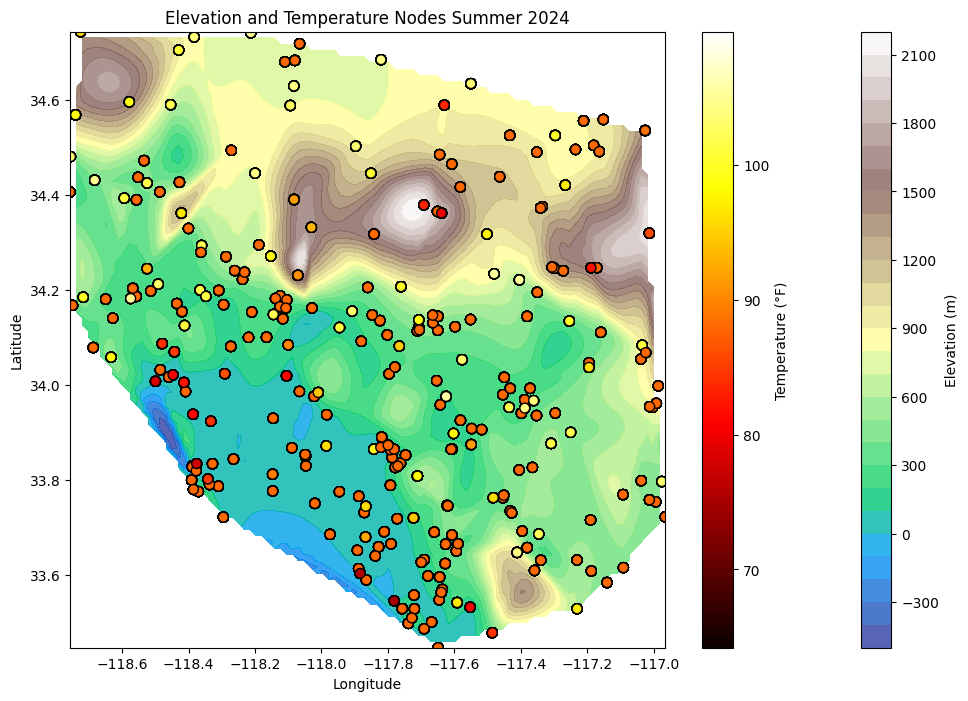

In [ ]:
#HEAT and ELEVATION

# Prepare the grid for elevation data
grid_x, grid_y = np.meshgrid(
    np.linspace(df_cleaned['LONGITUDE'].min(), df_cleaned['LONGITUDE'].max(), 100),
    np.linspace(df_cleaned['LATITUDE'].min(), df_cleaned['LATITUDE'].max(), 100)
)

# Interpolate elevation data onto the grid
grid_z_elevation = griddata(
    (df_cleaned['LONGITUDE'], df_cleaned['LATITUDE']),
    df_cleaned['ELEVATION'],
    (grid_x, grid_y),
    method='cubic'
)

# Plotting
plt.figure(figsize=(12, 8))

# Elevation contour map
plt.contourf(grid_x, grid_y, grid_z_elevation, levels=30, cmap='terrain', alpha=0.8)
plt.colorbar(label='Elevation (m)')

# Overlaying temperature data as colored nodes
# The color of each node is determined by its 'TMAX' value
scatter = plt.scatter(df1_with_location['LONGITUDE'], df1_with_location['LATITUDE'], c=df1_with_location['max'], cmap='hot', edgecolor='k', s=50)
plt.colorbar(scatter, label='Temperature (°F)')

plt.title(f'Elevation and Temperature Nodes Summer 2024')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
daily_avg_temps = df1_with_location.groupby('DATE')['max'].mean().reset_index(name='AvgTemp')

# Step 3: Identify the hottest day
hottest_day_info = daily_avg_temps.loc[daily_avg_temps['AvgTemp'].idxmin()]

hottest_day_info

NameError: name 'df1_with_location' is not defined